In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from models import *
from utils import *
from data import *
from configs import CONFIGS, EXP_CODES

In [2]:
'''
load saved experiment
'''


config_name = 'bird2d'
config = deepcopy(CONFIGS[config_name])

train_dataset, test_dataset, train_loader, test_loader = get_dataset_dataloader(config)


model_code = EXP_CODES[config_name][0]

fix_randomness(seed=42)

model = config['model_class'](seed=100, **config['model_args']).cuda()
model.load_state_dict(torch.load('./models/model_{}.pt'.format(model_code)))
_ = model.eval()

100%|██████████| 3000/3000 [00:00<00:00, 4653.87it/s]


In [3]:
'''
generate random trajectory from test dataset
'''


trajectory, gt_vs = test_dataset.generate_sample_trajectory(length=10000)

i1 = trajectory[:-1, :].unsqueeze(0).cuda()
i2 = trajectory[1:, :].unsqueeze(0).cuda()

with torch.no_grad():
    pred_vs = model_encoder(model=model, first_img=i1, second_img=i2)

    pred_vs = pred_vs.squeeze().cpu()


gt_velocities = np.array(gt_vs)
pred_velocities = np.array(pred_vs)
colors = test_dataset.cmap(gt_vs)

In [4]:
'''
remove outliers
'''


error, transformed_pred_velocities = compute_error_metric(
    true=gt_velocities,
    pred=pred_velocities,
    num_clusters=30,
    show_knee_visualization=False,
)

In [5]:
'''
compute firing rates given by model across true trajectory
'''


# compute true and predicted trajectories, with resampling
gt_x = gt_velocities.cumsum(axis=0)

resample_every = 40

pred_x = [np.zeros(2)]

for i in range(transformed_pred_velocities.shape[0]):
    if (i % resample_every) == 0:
        pred_x.append(gt_x[i, :])
    else:
        pred_x.append(pred_x[-1] + transformed_pred_velocities[i, :])

pred_x = np.stack(pred_x)[1:, :]



# hyperparams for synthetic grid cell model
num_grid_modules = 3
num_neurons_per_module = 30

max_firing_rate = 15 # hertz
baseline_firing_rate = 0.02 * max_firing_rate # out-of-field

T = 20 # total elapsed time in seconds

dt = 0.002 # in seconds
time = np.arange(dt, T + dt, dt)

base_grid_period = 0.35 * 8
grid_periods = base_grid_period + np.arange(num_grid_modules) * base_grid_period * np.sqrt(2)


# define 3 plane waves that generate regular triangular lattice.
# sum of cosine of dot product of position and b1, b2, b3 determines firing rate of cell at that position.
# firing rates then form a hexagonal grid.
# tl;dr: interference with these 3 vectors generates a hexagonal firing field/lattice.
b1 = np.array([0, 2/np.sqrt(3)]) # oriented vertically, contributes to up/down components of hexagonal pattern
b2 = np.array([1, -1/np.sqrt(3)]) # oriented with negative slope
b3 = np.array([1, 1/np.sqrt(3)]) # oriented with positive slope


# firing rates for all cells, for all modules
# randomly distributed spatial phases for all cells, for all modules
firing_rates = [np.zeros((num_neurons_per_module, len(time))) for _ in range(num_grid_modules)]
preferred_phases = [np.random.rand(num_neurons_per_module, 2) for _ in range(num_grid_modules)]


# generate grid cell rates over trajectory
for i in range(num_neurons_per_module):
    for j in range(num_grid_modules):
        phase_offset = preferred_phases[j][i, :].reshape(-1, 1) * np.ones((2, len(time)))

        cos1 = np.cos(2 * np.pi * (b1/grid_periods[j]).reshape(1, -1) @ (pred_x.T - phase_offset))
        cos2 = np.cos(2 * np.pi * (b2/grid_periods[j]).reshape(1, -1) @ (pred_x.T - phase_offset))
        cos3 = np.cos(2 * np.pi * (b3/grid_periods[j]).reshape(1, -1) @ (pred_x.T - phase_offset))
        
        firing_rates[j][i, :] = baseline_firing_rate + (max_firing_rate - baseline_firing_rate) * \
            np.maximum(0, (1/3) * (cos1 + cos2 + cos3) - 0.2)

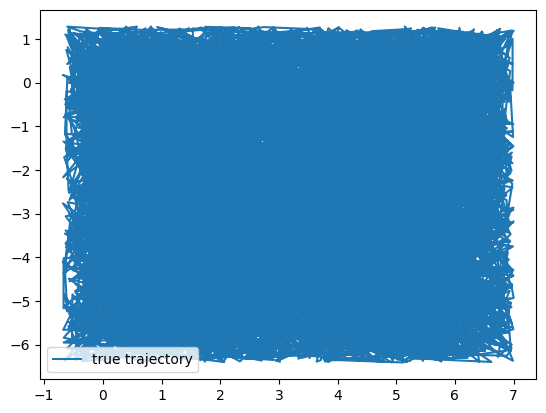

In [6]:
plt.figure()
plt.plot(gt_x[:, 0], gt_x[:, 1], label="true trajectory")
plt.legend()
plt.show()

[]

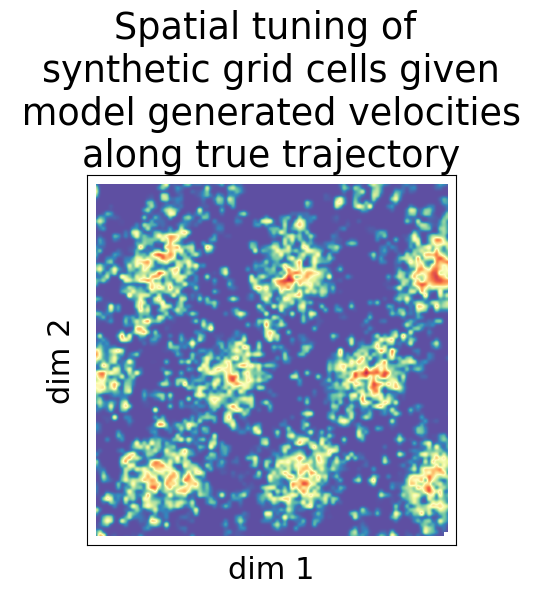

: 

In [15]:
'''
visualize spatial tuning of a cell at random: pick one cell from one module
'''
plt.rcParams.update({'font.size': 22})



cellind = np.random.randint(0, num_neurons_per_module)  
N = 100j

max_vals = gt_x.max(axis=0)
min_vals = gt_x.min(axis=0)

extent = [min_vals[0], max_vals[0], min_vals[1], max_vals[1]]

xs, ys = np.mgrid[extent[0]:extent[1]:N, extent[2]:extent[3]:N]

resampled = griddata((gt_x[:, 0], gt_x[:, 1]), firing_rates[0][cellind, :], (xs, ys))

fig = plt.figure()
plt.imshow(resampled.T, extent=extent, interpolation='gaussian', cmap='Spectral_r')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title('Spatial tuning of \nsynthetic grid cells given\n model generated velocities \nalong true trajectory')

ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])